In [85]:
import polars as pl 
import polars_ds as pds
import polars_xdt as xdt
import polars.selectors as cs
# To get the english dictionary
import nltk
import os 
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics 
from xgboost import XGBClassifier
import seaborn as sns 
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

ModuleNotFoundError: No module named 'polars_xdt'

## Read the data 

In [2]:
data = pl.read_csv('train.csv')

Clean the column names 

In [3]:
data = (data
.select(pl.all().name.map(lambda x:x.lower()))
.select(pl.all().name.map(lambda x:x.replace("-"," ")))
.select(pl.all().name.map(lambda x:x.replace(" ","_")))
)

data.head()

row_id,order_id,order_date,ship_date,ship_mode,customer_id,customer_name,segment,country,city,state,postal_code,region,product_id,category,sub_category,product_name,sales
i64,str,str,str,str,str,str,str,str,str,str,i64,str,str,str,str,str,f64
1,"""CA-2017-152156""","""08/11/2017""","""11/11/2017""","""Second Class""","""CG-12520""","""Claire Gute""","""Consumer""","""United States""","""Henderson""","""Kentucky""",42420,"""South""","""FUR-BO-10001798""","""Furniture""","""Bookcases""","""Bush Somerset Collection Bookc…",261.96
2,"""CA-2017-152156""","""08/11/2017""","""11/11/2017""","""Second Class""","""CG-12520""","""Claire Gute""","""Consumer""","""United States""","""Henderson""","""Kentucky""",42420,"""South""","""FUR-CH-10000454""","""Furniture""","""Chairs""","""Hon Deluxe Fabric Upholstered …",731.94
3,"""CA-2017-138688""","""12/06/2017""","""16/06/2017""","""Second Class""","""DV-13045""","""Darrin Van Huff""","""Corporate""","""United States""","""Los Angeles""","""California""",90036,"""West""","""OFF-LA-10000240""","""Office Supplies""","""Labels""","""Self-Adhesive Address Labels f…",14.62
4,"""US-2016-108966""","""11/10/2016""","""18/10/2016""","""Standard Class""","""SO-20335""","""Sean O'Donnell""","""Consumer""","""United States""","""Fort Lauderdale""","""Florida""",33311,"""South""","""FUR-TA-10000577""","""Furniture""","""Tables""","""Bretford CR4500 Series Slim Re…",957.5775
5,"""US-2016-108966""","""11/10/2016""","""18/10/2016""","""Standard Class""","""SO-20335""","""Sean O'Donnell""","""Consumer""","""United States""","""Fort Lauderdale""","""Florida""",33311,"""South""","""OFF-ST-10000760""","""Office Supplies""","""Storage""","""Eldon Fold 'N Roll Cart System""",22.368


## Null values

Replacing empty values with null values. Only postal_code contains null values (11 nulls)

In [4]:
# It is not possible to check if numeric columns contains empty data ("" or " ")
(data
 .select(pl.all().exclude(pl.String),
         pl.when(
    (cs.string()==" ")|(cs.string()==""))
            .then(pl.lit(None))
            .otherwise(cs.string())
            .name.keep())
.null_count()
)



row_id,postal_code,sales,order_id,order_date,ship_date,ship_mode,customer_id,customer_name,segment,country,city,state,region,product_id,category,sub_category,product_name
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,11,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Preprocessing

Changing the format on date columns. Extracting year, month and day from the function.

In [5]:
# Function for changing the date format
def change_format(data,c):
 data = (data
 .with_columns(pl.col(c).str.split("/"))
 .with_columns(pl.col(c).list.get(0).alias(c+"_"+'day'),
              pl.col(c).list.get(1).alias(c+"_"'month'),
              pl.col(c).list.get(2).alias(c+"_"'year'))
 .with_columns(pl.concat_str([c+"_"'year',c+"_"'month',c+"_"'day'],separator="-").alias(c))
 .with_columns(pl.col(c).cast(pl.Date))
                                 )
 return data





In [6]:
# Changing format
data = (data
.pipe(function=change_format,c = 'order_date')
.pipe(function=change_format,c = 'ship_date')
)


## Descriptive statistics

### Aggregate on year

In [74]:
agg_year = (data
.group_by(pl.col('order_date_year').cast(pl.Int64))
.agg(n_observations = pl.len(),
     n_unique_customers = pl.col('customer_id').n_unique(),
     n_unique_products = pl.col('product_id').n_unique(),
     sum_sales = pl.col('sales').sum())
.sort(by = 'order_date_year')
)

agg_year

order_date_year,n_observations,n_unique_customers,n_unique_products,sum_sales
i64,u32,u32,u32,f64
2015,1953,589,1215,479856.2081
2016,2055,567,1226,459436.0054
2017,2534,635,1356,600192.55
2018,3258,690,1518,722052.0192


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


<Axes: xlabel='order_date_year', ylabel='sum_sales'>

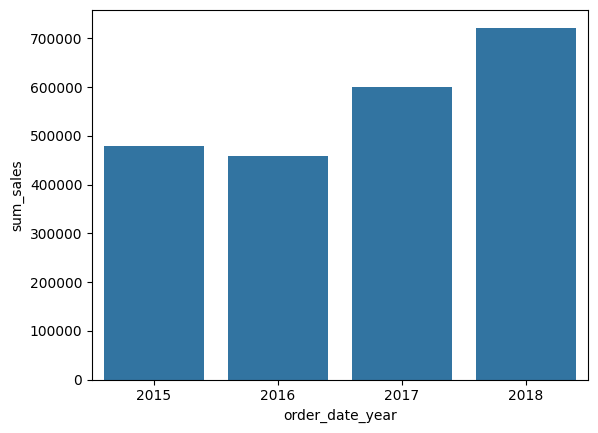

In [71]:
sns.barplot(data = agg_year.to_pandas(),x = 'order_date_year',y = 'sum_sales')

### Monthly sales

In [96]:
agg_month = (data
.group_by(pl.col('order_date'))
.agg(n_observations = pl.len(),
     n_unique_customers = pl.col('customer_id').n_unique(),
     n_unique_products = pl.col('product_id').n_unique(),
     sum_sales = pl.col('sales').sum())
.sort(by = 'order_date',descending = False)
)

# Checking if there are any missing dates
(agg_month
.with_columns(diff = pl.col('order_date')-pl.col('order_date').shift(1).cast(pl.Int64))
.filter(pl.col('order_date').dt.year()==2018,pl.col('order_date').dt.month()==9)
)

order_date,n_observations,n_unique_customers,n_unique_products,sum_sales,diff
date,u32,u32,u32,f64,i64
2018-09-01,7,5,7,1261.81,1
2018-09-02,33,13,33,8652.334,1
2018-09-03,13,8,13,1595.849,1
2018-09-04,28,16,28,5360.202,1
2018-09-05,5,3,5,327.044,1
…,…,…,…,…,…
2018-09-25,13,7,13,1412.213,1
2018-09-26,7,3,7,1486.576,1
2018-09-28,10,5,10,559.271,2


In [94]:
import holidays
holidays.US(years = 2018).items()

for ptr in holidays.US(years = 2018).items():
    print(ptr)

(datetime.date(2018, 1, 1), "New Year's Day")
(datetime.date(2018, 5, 28), 'Memorial Day')
(datetime.date(2018, 7, 4), 'Independence Day')
(datetime.date(2018, 9, 3), 'Labor Day')
(datetime.date(2018, 11, 11), 'Veterans Day')
(datetime.date(2018, 11, 12), 'Veterans Day (observed)')
(datetime.date(2018, 11, 22), 'Thanksgiving')
(datetime.date(2018, 12, 25), 'Christmas Day')
(datetime.date(2018, 1, 15), 'Martin Luther King Jr. Day')
(datetime.date(2018, 2, 19), "Washington's Birthday")
(datetime.date(2018, 10, 8), 'Columbus Day')


### Category and subcategory

In [19]:
category_and_sub = (data
.group_by('order_date_year','category','sub_category')
.agg(pl.col('sales').sum())
.with_columns(pl.col('sales').sum().over('category','order_date_year').alias('total_category_sum'),
              pl.col('sub_category').n_unique().over('category','order_date_year').alias('n_unique_products'))
.sort(by = ['category','order_date_year','sales'])
)

# Partition the data, such that it can be looped over when creating figs.
category_and_sub_part = category_and_sub.partition_by(by=['category'])

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should

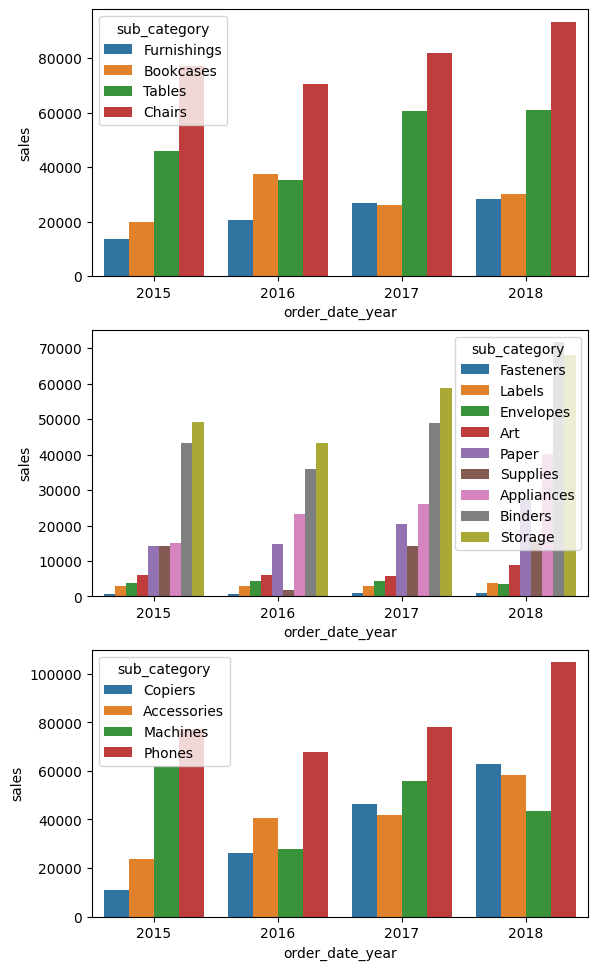

In [59]:
# Creating subplot axes
fig, ax = plt.subplots(3,1)

for (index,category) in enumerate(category_and_sub_part):
  ax[index] = sns.barplot(data = category.to_pandas(),x = 'order_date_year',y = 'sales',hue = 'sub_category',ax = ax[index])

# Adjust the spacing
plt.subplots_adjust(top=2)
